In [306]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QAOA_realestate"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [130]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from sklearn.preprocessing import MinMaxScaler

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [131]:
def transform_window(x,window):
    x = np.asarray(x)
    window_x = []
    for i in range(len(x)-window):
        window_x += [np.exp(sum([np.log(1+x[i+j]) for j in range(window)]))]
    return window_x

def MSE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred)**2

def MAE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred,1)

def R_square(y_true,y_pred):
    return 1-np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true))**2

def k_lookback(y,look_back=5):
    n = len(y)
    y = np.asarray(y)
    y_lb = pd.DataFrame(y[look_back:])
    for i in range(1,look_back):
        y_lb[i] = np.asarray(y)[look_back-i:n-i]
    return y_lb.iloc[:,1:].values

In [132]:
X1 = pd.read_csv("data/Preprocessed_Data/X1.csv",index_col="Unnamed: 0")
y = pd.read_csv("data/Preprocessed_Data/Y.csv")

In [290]:
num_epochs = 3000 #1000 epochs
learning_rate = 0.001 #0.001 lr

look_back = 5
input_size = look_back-1 #number of features
hidden_size = 16 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
device = torch.device("cpu")

window = 6
ratio = 0.8

In [291]:
X_window = transform_window(X1.iloc[:,1],window)
y_window = transform_window(y.iloc[:,1],window)
train_split = int(len(X_window)*ratio)

In [293]:
X_df = np.array([[i,j] for i,j in zip(k_lookback(y_window,look_back=look_back),k_lookback(X_window,look_back))])
train_split = int(ratio*len(X_df))

X_train = X_df[:train_split,:]
X_test = X_df[train_split:,:]
y_train = np.array(y_window)[look_back:train_split+look_back]
y_test = np.array(y_window)[train_split+look_back:]

X_train_tensors_final = Variable(torch.Tensor(X_train))
X_test_tensors_final = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [294]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
loss_function = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = loss_function(outputs.squeeze(), y_train_tensors.to(device))
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop

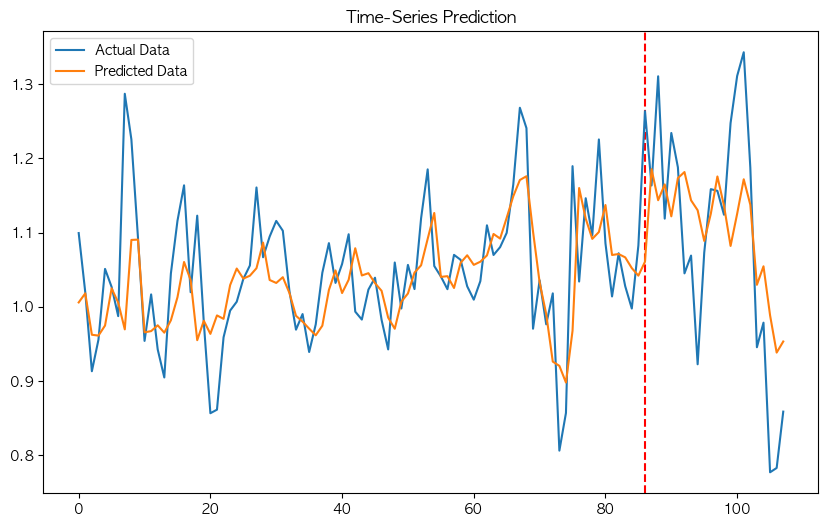

In [295]:
train_predict = lstm1(X_train_tensors_final.to(device)).detach().numpy()#forward pass
test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy()#forward pass
data_predict = np.concatenate([train_predict.reshape(-1),test_predict.reshape(-1)])
dataY_plot = np.concatenate([y_train_tensors.numpy(),y_test_tensors.numpy()])

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_split, c='r', linestyle='--') #size of the training set
plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [296]:
train_split = int(ratio*len(X_df))

X_train = X_df[:train_split,:]
X_test = X_df[train_split:,:]
y_train = np.array(y_window)[look_back:train_split+look_back]
y_test = np.array(y_window)[train_split+look_back:]

X_train_tensors_final = Variable(torch.Tensor(X_train))
X_test_tensors_final = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

results =pd.DataFrame()
y_test_data =y_test_tensors.numpy()
y_mean = [np.mean(y_train_tensors.numpy()) for i in range(len(y_test_data))]
y_model = test_predict.reshape(-1)

result = pd.Series([MSE(y_test_data,y_mean),
MSE(y_test_data,y_model),
MAE(y_test_data,y_mean),
MAE(y_test_data,y_model),
R_square(y_test_data,y_mean),
R_square(y_test_data.reshape(-1),y_model)]
)
results["1"] =result
results.index = np.array(["MSE_mean","MSE_model","MAE_mean","MAE_model","Rsquare_mean","Rsquare_model"])

In [297]:
results

,1
MSE_mean,0.651896
MSE_model,0.337447
MAE_mean,3.277979
MAE_model,2.256230
Rsquare_mean,-0.127406
Rsquare_model,0.416410


In [303]:
R_square_list = []  
for dong in range(1,y.shape[1]):
  X_window = transform_window(X1.iloc[:,1],window)
  y_window = transform_window(y.iloc[:,dong],window)
  train_split = int(len(X_window)*ratio)
  X_df = np.array([[i,j] for i,j in zip(k_lookback(y_window,look_back=look_back),k_lookback(X_window,look_back))])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_train = np.array(y_window)[look_back:train_split+look_back]
  y_test = np.array(y_window)[train_split+look_back:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))
  lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
  loss_function = torch.nn.L1Loss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

  for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function
    loss = loss_function(outputs.squeeze(), y_train_tensors.to(device))
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    
  y_test_data =y_test_tensors.numpy()
  y_model = test_predict.reshape(-1)
  R_square_list += [R_square(y_test_data.reshape(-1),y_model)]

In [311]:
R_square_list_mean = [] 

for dong in range(1,y.shape[1]):
    y_window = transform_window(y.iloc[:,dong],window)
    train_split = int(ratio*len(X_df))
    y_test = np.array(y_window)[train_split+look_back:]
    y_train = np.array(y_window)[look_back:train_split+look_back]
    y_mean = [np.mean(y_train) for i in range(len(y_test))]
    R_square_list_mean += [R_square(y_test,y_mean)]

<function matplotlib.pyplot.show(close=None, block=None)>

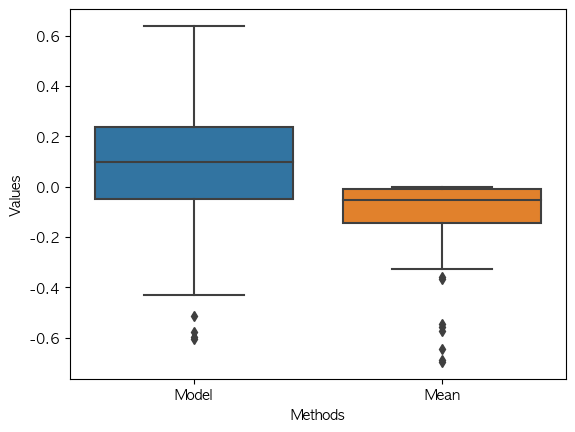

In [317]:
plot_data = [R_square_list+R_square_list_mean,["Model" for i in range(y.shape[1]-1)]+["Mean" for i in range(y.shape[1]-1)]]
plot_data = pd.DataFrame(plot_data).T
plot_data.columns = ["Values","Methods"]
sns.boxplot(data = plot_data,x= "Methods", y="Values")
plt.show

In [338]:
X_cumlative = [np.exp(sum(np.log(1+X1.iloc[:i,1]))) for i in range(len(X1))]

In [339]:
y_cumlative = [np.exp(sum(np.log(1+y.iloc[:i,1]))) for i in range(len(X1))]

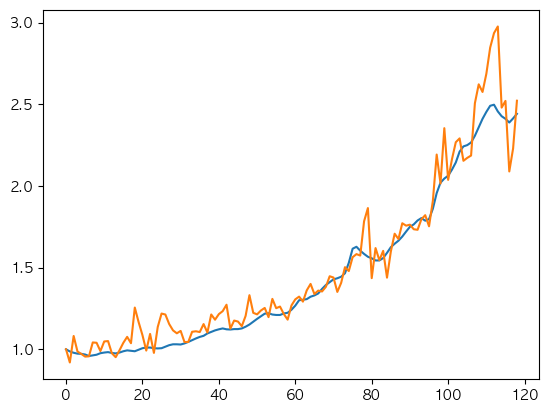

In [341]:
n = len(X_cumlative)
plt.plot(range(n),X_cumlative)
plt.plot(range(n),y_cumlative)
plt.show()

In [350]:
X_data = X_cumlative 
y_data = y_cumlative 

num_epochs = 3000 #1000 epochs
learning_rate = 0.001 #0.001 lr

look_back = 5
input_size = look_back-1 #number of features
hidden_size = 40 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
device = torch.device("cpu")

window = 6
ratio = 0.8

In [351]:
X_df = np.array([[i,j] for i,j in zip(k_lookback(y_data ,look_back=look_back),k_lookback(X_data ,look_back))])
train_split = int(ratio*len(X_df))

X_train = X_df[:train_split,:]
X_test = X_df[train_split:,:]
y_train = np.array(y_data)[look_back:train_split+look_back]
y_test = np.array(y_data)[train_split+look_back:]

X_train_tensors_final = Variable(torch.Tensor(X_train))
X_test_tensors_final = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
loss_function = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = loss_function(outputs.squeeze(), y_train_tensors.to(device))
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop

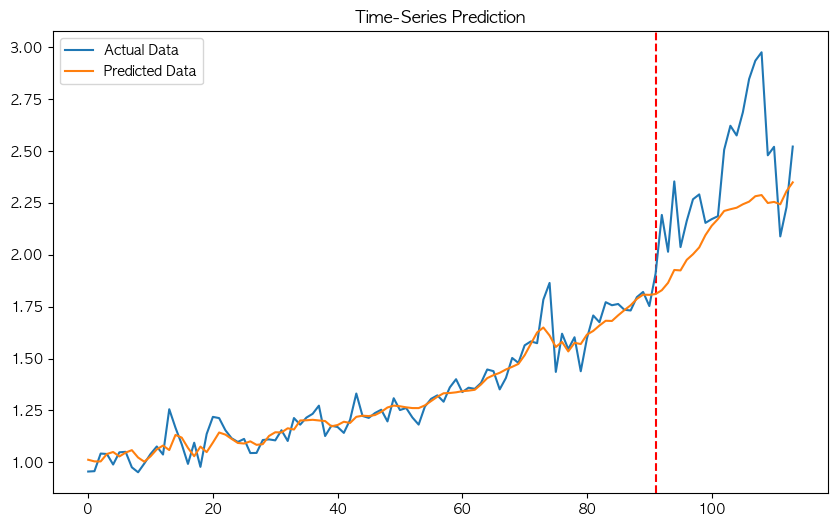

In [352]:
train_predict = lstm1(X_train_tensors_final.to(device)).detach().numpy()#forward pass
test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy()#forward pass
data_predict = np.concatenate([train_predict.reshape(-1),test_predict.reshape(-1)])
dataY_plot = np.concatenate([y_train_tensors.numpy(),y_test_tensors.numpy()])

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_split, c='r', linestyle='--') #size of the training set
plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 